# Counterbalance student assignments
Taylor Burke, January 2022; updated by Natalia Vélez, January 2022

#### Constraints:
1. Each student only sees one problem once
2. Each student sees 40 problems total
3. There are missing problems and teachers.

#### Balancing:
1. The no. of students each teacher's problem is shown to (ideally, 5)
2. The no. of teachers each student gets shown (each student sees every teacher at least once)

#### Goal:
  
1. Generate a list of the optimal counterbalanced trial orderings.

In [1]:
import random, sys, json
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt 
from ast import literal_eval
from tqdm import tqdm
from random import shuffle

sys.path.append('..')
from utils import int_extract, write_json

from configparser import ConfigParser
from mysql.connector import MySQLConnection, Error

## Load teacher data

Here, we'll load the behavioral data from the fMRI task to identify valid teacher/problem pairings

In [2]:
excluded = np.loadtxt('../1_preprocessing/outputs/excluded_participants.txt', dtype=str)
excluded = [int_extract('(?<=sub-)[0-9]+', s) for s in excluded]

teaching_df = pd.read_csv('../2_behavioral/outputs/teaching_behavior.csv')
teaching_df = teaching_df[~teaching_df.subject.isin(excluded)]
teaching_df = teaching_df.dropna(subset=['example'])
teaching_df['example'] = teaching_df['example'].apply(literal_eval)
teaching_df['order'] = teaching_df['order'].apply(literal_eval)

n_hints = (teaching_df
           .groupby(['subject','problem'])['ex_idx']
           .agg('count')
           .reset_index()
           .rename(columns={'subject': 'teacher'}))
valid_hints = n_hints[n_hints.ex_idx > 1].copy()

print('Found %i valid teacher-problem combinations' % valid_hints.shape[0])
valid_hints.head()

Found 1111 valid teacher-problem combinations


,teacher,problem,ex_idx
0,1,0,3
1,1,1,3
2,1,2,3
3,1,3,3
4,1,4,3


Make a matrix of teachers x hints, where each cell represents the number of times that a hint has already been assigned.
By default, invalid teacher-problem pairings have a value of `maxint` so that they're never selected.

In [3]:
hint_mtx = valid_hints.pivot(index='teacher', columns='problem', values='ex_idx')
hint_mtx[np.isnan(hint_mtx)] = np.inf
hint_mtx[np.isfinite(hint_mtx)] = 0

We'll also format teachers' hints correctly, to save them alongside the assignments

In [4]:
hint_bank = {}

for sub, sub_data in valid_hints.groupby('teacher'):
    sub_id = 'sub-%02d' % sub
    hint_bank[sub_id] = {}
    
    for _, block in sub_data.iterrows():
        # read in examples for each problem
        prob = block.problem
        prob_data = teaching_df[(teaching_df.subject == sub) & (teaching_df.problem == prob)]
        
        # initialize state
        state = np.zeros((6,6), dtype=int)
        state_list = []
        
        # update state after each example
        for _, trial in prob_data.iterrows():
            state[trial.example[0], trial.example[1]] = 1
            state_t = state.copy()
            state_list.append(state_t.tolist())
            
        # add states to hint bank
        hint_bank[sub_id][prob] = {'order': trial.order, 'states': state_list}

In [5]:
hint_bank['sub-10'][0] # let's test it out!

{'order': ['B', 'C', 'D', 'A'],
 'states': [[[0, 0, 1, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0]],
  [[0, 0, 1, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0]],
  [[0, 0, 1, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0]]]}

## Functions for visually evaluating assignments

In [6]:
def plot_problem_distribution(all_teacher_problem_counts):
    plt.figure(figsize=(16,9))
    plt.xlabel("Problem No.")
    plt.ylabel("Teacher ID")
    plt.title('Frequency of Problem Assignments')
    sns.heatmap(all_teacher_problem_counts, linewidths=.5, annot=True, cmap="YlGnBu")
    plt.show()

def plot_student_distribution(all_teacher_problem_counts):
    # remove inf values    
    values, counts = np.unique(all_teacher_problem_counts, return_counts=True)
    nan_loc = np.isfinite(values)
    values = values[nan_loc]
    counts = counts[nan_loc]
    
    bars =  plt.bar(values, counts)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
        
    plt.xticks(values)
    plt.xlabel("No. of Students Assigned to a problem")
    plt.ylabel("Count")
    plt.title('Frequency of Students Across Problems')
    plt.show()
    
def plot_teacher_distribution(all_teacher_problem_counts):
    unique_teacher_frequency = defaultdict(lambda: 0)

    for student_assignments in all_student_assignments:
        unique_teacher_frequency[len(np.unique(student_assignments))] += 1

    unique_teachers = list(unique_teacher_frequency.keys())
    unique_teacher_counts = [unique_teacher_frequency[value] for value in unique_teachers]
    
    bars = plt.bar(unique_teachers, unique_teacher_counts)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.xlabel("No. of Teachers Assigned to a student")
    plt.ylabel("Count")
    plt.title('Frequency of Teachers Across Students')
    plt.show()
    
    mean_unique_teachers = np.mean(unique_teachers)
    print("Each student sees on average {} teachers".format(mean_unique_teachers))
    
    
def visualize_distributions(all_student_assignments, all_teacher_problem_counts):
    plot_problem_distribution(all_teacher_problem_counts)
    plot_student_distribution(all_teacher_problem_counts)
    plot_teacher_distribution(all_teacher_problem_counts)
    print("There are {} unique trial orders".format(len(np.unique(all_student_assignments, axis=0))))

## Distribute hints

In [7]:
def counterbalance_assignments():
    teachers = hint_mtx.index.values
    problems = hint_mtx.columns.values

    num_teachers = len(teachers)
    num_problems = len(problems) # Number of problems in the the teaching experiment. 
    num_students = num_teachers*5 # The target number of participants in the student experiment.

    # Matrix containing assigned teacher IDs that is indexed by student ID then problem ID
    all_student_assignments = np.zeros((num_students, num_problems), dtype=int)

    # Matrix containing problem counts (no. of times problem has been assigned to a student) 
    # that is indexed by teacher ID then problem ID
    all_teacher_counts = hint_mtx.copy()

    for student in range(num_students):
        seen_teachers = set()

        for problem in problems:

            teacher_counts = all_teacher_counts[problem]
            lowest_count = teacher_counts.min()

            # Once all teachers have been seen, students can relearn from teachers again.
            if len(seen_teachers) == num_teachers:
                seen_teachers = set()
                unseen_teachers_with_lowest_count = set(teachers)

            # # Find the student's unseen teachers who have presented this problem the least amount of times.
            teachers_with_lowest_count = set(teacher_counts[teacher_counts == lowest_count].index)
            unseen_teachers_with_lowest_count = teachers_with_lowest_count.difference(seen_teachers)

            # If there are no unseen teachers with the lowest count, try finding a seen teacher with the lowest count.
            if len(unseen_teachers_with_lowest_count) == 0:
                unseen_teachers_with_lowest_count = teachers_with_lowest_count

            # Randomly select a teacher's problem to assign to a student.
            teacher = random.sample(unseen_teachers_with_lowest_count, 1)[0]

            # # Updata variables based on the new assignment.
            all_student_assignments[student,problem] = teacher
            all_teacher_counts[problem][teacher] += 1
            seen_teachers.add(teacher)

    return all_student_assignments, all_teacher_counts

In [8]:
test_students, test_teachers = counterbalance_assignments() # let's test it out!

## Find best counterbalanced assignments

Criterion: How many students see each hint?

In [9]:
def evaluate_distributions(all_student_assignments, all_teacher_problem_counts):
    
    unique_counts = np.unique(all_teacher_problem_counts)
    unique_counts = unique_counts[np.isfinite(unique_counts)]

    # If not every problem is only shown 5 or 6 times, return the average no. of teachers each student sees.
    if min(unique_counts) < 5 or max(unique_counts) > 6:
        unique_teacher_frequency = defaultdict(lambda: 0)

        for student_assignments in all_student_assignments:
            unique_teacher_frequency[len(np.unique(student_assignments))] += 1

        unique_teachers = list(unique_teacher_frequency.keys())
        return np.mean(unique_teachers), unique_teacher_frequency[28]
    
    return 0, 0

In [10]:
evaluate_distributions(test_students, test_teachers) # let's test it out!

(0, 0)

Pick the best of 100 assignments:

100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


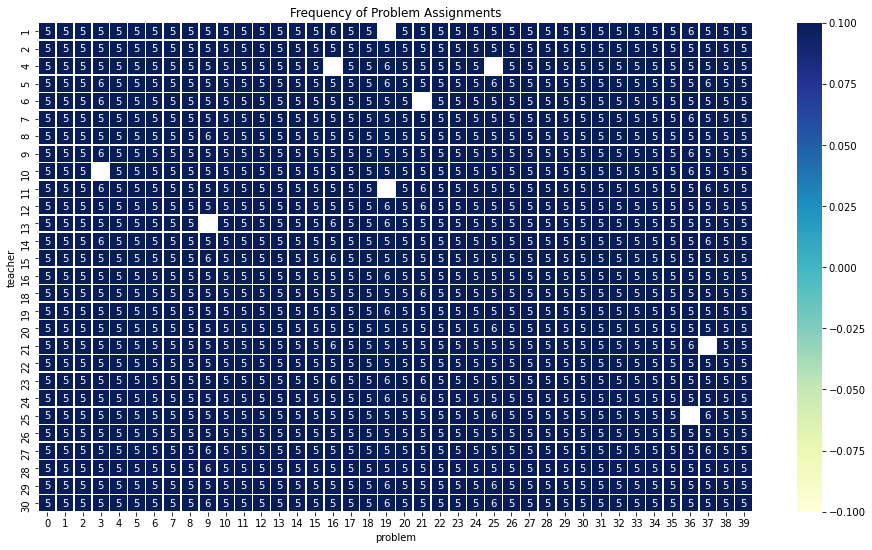

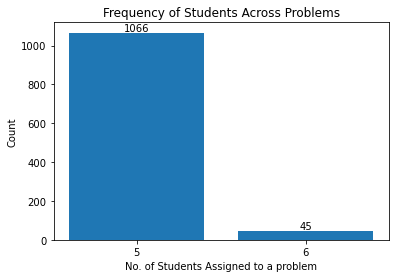

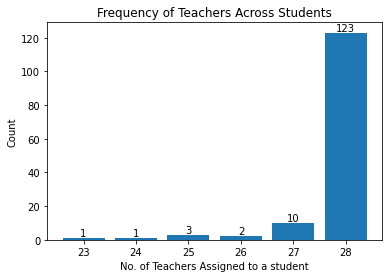

Each student sees on average 25.5 teachers
There are 140 unique trial orders


In [11]:
np.random.seed(1234)

# initialize assignments
best_all_student_assignments, best_all_teacher_problem_counts = counterbalance_assignments()
best_avg_teachers_seen, best_num_students_seen_all_teachers = evaluate_distributions(best_all_student_assignments, 
                                                                                     best_all_teacher_problem_counts)

# select best of 100
n_iter = 100
for __ in tqdm(range(n_iter)):
    all_student_assignments, all_teacher_problem_counts = counterbalance_assignments()
    avg_teachers_seen, num_students_seen_all_teachers = evaluate_distributions(all_student_assignments, all_teacher_problem_counts)
    
    # Maximizing the average number of unique teachers that students see
    if avg_teachers_seen >= best_avg_teachers_seen and num_students_seen_all_teachers >= best_num_students_seen_all_teachers:
        best_all_student_assignments = all_student_assignments
        best_all_teacher_problem_counts = all_teacher_problem_counts
        best_num_students_seen_all_teachers = num_students_seen_all_teachers

# show best distribution
visualize_distributions(best_all_student_assignments, best_all_teacher_problem_counts)

Format the winning assignment:

In [12]:
assignments_df = (
    pd.DataFrame(best_all_student_assignments)
    .reset_index()
    .melt(id_vars='index', var_name='problem', value_name='teacher')
    .rename(columns={'index': 'student'})
    .sort_values(by=['student', 'problem'])
    .reset_index(drop=True)
)

assignments_df

,student,problem,teacher
0,0,0,15
1,0,1,30
2,0,2,4
3,0,3,11
4,0,4,24
...,...,...,...
5595,139,35,18
5596,139,36,10
5597,139,37,27
5598,139,38,30


## Sanity check: Do the best assignments satisfy all constraints?

(1) Are the student, problem, teacher indices in the right range?

In [13]:
assignments_df.agg(['min', 'max', 'nunique'])

,student,problem,teacher
min,0,0,1
max,139,39,30
nunique,140,40,28


(2) Does each student see every problem exactly once?

In [14]:
n_problems = assignments_df.groupby('student')['problem'].nunique()
np.any(n_problems != 40)

False

(3) Do the missing teacher-problem in the student assignments correspond to missing teacher data?

In [15]:
n_ratings = (assignments_df
             .groupby(['teacher', 'problem'])['student']
             .agg('nunique')
             .reset_index())
shared_cols = ['teacher', 'problem']

# get combos in assignments, teacher data
assignment_combos = n_ratings[shared_cols].copy().drop_duplicates()
hint_combos = valid_hints[shared_cols]

# merge combos
merged_combos = valid_hints.merge(assignment_combos, on=shared_cols, how='outer', indicator=True)

print('%i teacher-problem combinations in assignments' % assignment_combos.shape[0])
print('%i teacher-problem combinations in behavioral data' % valid_hints.shape[0])

# any conflicts?
np.any(merged_combos._merge != 'both')

1111 teacher-problem combinations in assignments
1111 teacher-problem combinations in behavioral data


False

## Save assignments

Save teacher-problem pairings:

In [16]:
assignments_df.to_csv('outputs/all_assignments.csv')

Format trial orders:

In [17]:
assignments_list = []
for student, group in assignments_df.groupby('student'):
    student_list = []
    for _, prob_data in group.iterrows():
        # parse trial info
        teacher = 'sub-%02d' % prob_data.teacher
        prob = prob_data.problem        
        hints = hint_bank[teacher][prob]
        
        prob_assignment = {
            'teacher': teacher,
            'problem': prob
        }
        prob_assignment = {**prob_assignment, **hints}
        
        student_list.append(prob_assignment)
        
    # shuffle problems
    shuffle(student_list)
    assignments_list.append(student_list)

Save to file:

In [18]:
write_json(assignments_list, 'outputs/all_trial_orders.json')

Upload to database:

In [20]:
dbentries = [(student, json.dumps(student_order)) for (student, student_order) in enumerate(assignments_list)]

## UPLOAD TO DATABASE
# Read config file
def read_db_config(filename='config.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)

    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))

    return db

# Main method: Uploads trial orders to database, indexed by student ID
def insert_assignments(data):
    query = "INSERT INTO student_assignments_debug(student_id,trial_order) " \
            "VALUES(%s,%s)"

    try:
        db_config = read_db_config()
        conn = MySQLConnection(**db_config)

        cursor = conn.cursor()
        cursor.executemany(query, data)

        conn.commit()
    except Error as e:
        print('Error:', e)

    finally:
        conn.close()

insert_assignments(dbentries)

Error: 2003: Can't connect to MySQL server on 'opal3.opalstack.com:3306' (110 Connection timed out)


UnboundLocalError: local variable 'cursor' referenced before assignment